In [1]:
from numba import jit

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm


Bad key "text.kerning_factor" on line 4 in
/Users/vsalinas/miniconda3/envs/gui/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
e_0 = 8.854*1e-12
k   = (1/(4*np.pi*e_0))
#Based on: https://www.mathworks.com/matlabcentral/fileexchange/42773-electric-field-of-a-parallel-plate-capacitor-using-2d-poisson-equation
#-------------------------------------------------------------------------%
#                         INITIALIZATION                                  
#          Here, all the grid, size, charges, etc. are defined
#-------------------------------------------------------------------------%
# Enter the dimensions
Nx = 101     # Number of X-grids
Ny = 101     # Number of Y-grids

Ni = 750#750  # Number of iterations for the Poisson solver
T = 0#            % Top-wall potential
B = 0#            % Bottom-wall potential
L = 0#            % Left-wall potential
R = 0#            % Right-wall potential


#for computing potential at grid center
mpx = np.ceil(Nx/2) # Mid-point of x
mpy = np.ceil(Ny/2) # Mid point of y

#define domain mesh
x = np.linspace(0,100,Nx+1)#Nx+1)-mpx
y = np.linspace(0,25,Ny+1)#Ny+1)-mpy
xm,ym = np.meshgrid(x,y)

In [4]:
@jit
def e_br(z,paper):
    '''
    Compute critical electric field from initiation altitudes. (Eq. 5)
    Note: does not assume RBE as breakdown mechanism, simply
          allows for approximation of electric field upon
          flash initiation. 
          
          args: z = initiation altitude in km 
                     MUST CONVERT FROM INDEX TO ALTITUDE 
                     USING GRID SPACING:
                     
                     z(km) = (z*125) * 1e-3
                     
          returns: e_critical in kV/m
    '''
    rho_a = 1.208 * np.exp(-(z/8.4))
    if paper =='m01':
        return 232.6*rho_a#167.*rho_a
    else:
        return 167*rho_a

Setup:
----

In [5]:
@jit
def solver(xi,xf,zt,zb):
    #-------------------------------------------------------------------------%
    #Setup Geometry: Plate Area and Separation
    #-------------------------------------------------------------------------%
    xleft,xright = (xi,xf)#25,85
    zt = zt#12
    zb = zb#8
    Le = (xright-xleft)*1e3 #Plate Length
    d  = (zt-zb)*1e3
    zinit=(zt+zb)/2

    #-------------------------------------------------------------------------%
    #Find grid points where plate exists given its start and end points
    #-------------------------------------------------------------------------%
    xvalid = np.where((x>=xleft) & (x<=xright))[0]
    lp = np.floor(xvalid.shape[0]/2)
    lshape = xvalid.shape[0]
    mpx = xvalid[int(xvalid.shape[0]/2)]

    pp1 = np.where(np.abs(y-zt)==np.abs(y-zt).min())[0][0]#Top plate grid location
    pp2 = np.where(np.abs(y-zb)==np.abs(y-zb).min())[0][0]#Bottom plate grid location
    zvalid = np.arange(pp2,pp1,1)
    mpy = zvalid[int(zvalid.shape[0]/2)]

    #-------------------------------------------------------------------------%
    # Initializing edges potentials
    #-------------------------------------------------------------------------%
    V = np.zeros([Nx+1,Ny+1])#   % Potential (Voltage) matrix
    V[0,:] = L
    V[Nx,:] = R
    V[:,0] = B
    V[:,Ny] = T
    #-------------------------------------------------------------------------%
    # Initializing Corner potentials
    #-------------------------------------------------------------------------%
    V[0,0]   = 0.5*(V[0,1]+V[1,0])
    V[Nx,0]  = 0.5*(V[Nx-1,0]+V[Nx,1])
    V[0,Ny]  = 0.5*(V[0,Ny-1]+V[1,Ny])
    V[Nx,Ny] = 0.5*(V[Nx,Ny-1]+V[Nx-1,Ny])
    
    #-------------------------------------------------------------------------%
    #Initiliazed Details:
    #-------------------------------------------------------------------------%
    z_init   = (zt+zb)/2                           #Init alt
    e_init   = e_br(z_init,'m01')*1e3              #Init Efield
    sig_crit = e_0 * e_init                        #Init surface charge
    sigma    = e_0 * (e_init/xm.flatten().shape[0])#sig_crit/((lshape*lshape))  #Distributed surface charge on plate (dq/da)
    lam      = sigma*(Le/x.shape[0]) #q/Le         #Line Charge

    #-------------------------------------------------------------------------%
    #Potential of finite charge rod for initialization.
    #-------------------------------------------------------------------------%
    ###DISTRIBUTE E INTO ALL GRID CELLS FOR A dE/dxi ESTIMATE
    #Finite Charge Rod:
    #v_cap = (k*lam*np.log(( (Le/x.shape[0]) + np.sqrt((Le/x.shape[0])**2. + (zinit*1e3)**2.))/(zinit*1e3))) 
    
    #Capacitor:#
#     v_cap = (e_init/(xm.flatten().shape[0])) * (d/(y.shape[0]))
    #v_cap = ((sig_crit/xm.flatten().shape[0])/e_0) * (d/zvalid.shape[0])
    
    #FORCE LARGEST ELECTRIC FIELD BETWEEN PLATES:
#     v_cap = (e_init/(lshape**2 * zvalid.shape[0])) * (d/zvalid.shape[0])
    v_cap = (e_init/(lshape * np.where((y>zb) * (y<zt))[0].shape[0])) * (d/np.where((y>zb) * (y<zt))[0].shape[0])


    #-------------------------------------------------------------------------%
    #Iterate Solution:
    #-------------------------------------------------------------------------%
    for z in np.arange(0,Ni):    # Number of iterations  
        for i in np.arange(0,Nx-1):
            for j in np.arange(0,Ny-1):      
                # The next two lines are meant to force the matrix to hold the 
                # potential values for all iterations along each finite uniformily charged rod
                V[int(pp1),int(mpx-lp):int(mpx+lp)] = v_cap
                V[int(pp2),int(mpx-lp):int(mpx+lp)] = -v_cap
                
                V[i,j]=0.25*(V[i+1,j]+V[i-1,j]+V[i,j+1]+V[i,j-1])# + ((hx_dual*hy_dual)*charge[i,j]/e_0))

    # Take transpose for proper x-y orientation to get Efield
    V = V.T
    Ex,Ey=np.gradient(V)
    Ex = -Ex
    Ey = -Ey
    
    #-------------------------------------------------------------------------%
    #compute magnitude:
    #-------------------------------------------------------------------------%
    e_total = np.sqrt(Ex**2.+Ey**2.)
    e_btw   = np.ma.MaskedArray(e_total.T,mask=~((xm>xleft) & (xm<xright) & (ym>zb) & (ym<zt))).T #between the plates
    
    
    #Get middle E field sample between plates and scale up:
    #domain_size       = (x.shape[0]*y.shape[0])
    #volume_btw_plates = (np.where((x>xleft) & (x<xright))[0].shape[0] * np.where((y>zb) & (y<zt))[0].shape[0])
    #scale_factor      = (domain_size)/volume_btw_plates
    #emid      = e_total[xmid_ind,ymid_ind] * (lp**2. + zvalid.shape[0])

    #-------------------------------------------------------------------------%
    #Get Stats:
    #-------------------------------------------------------------------------%
    #Stats: EFIELD
    adjust_Efield = 1

    ref_efield = e_init*1e-3
    dom_efield = (e_total).sum()*1e-3
    btw_efield = (e_btw.sum())*1e-3 #| Use emid if forcing de_init between plates
    sig_init   = sig_crit
    dsig_init  = sigma
    
    force_scale = btw_efield/(e_init*1e-3)
    btw_efieldz = btw_efield/force_scale
    e_ratio     = dom_efield/btw_efield
    dom_efieldz = (dom_efield/force_scale) 
    #Stats: Energy:
    w_cap = (e_0/2) * (2*(e_init))**2. * ((Le*Le) * d) #adjust efield instead of W gives results similar to those of Boccippio? Makse physical sense though.
    dom_energy = (e_0/2) * (2*dom_efieldz*1e3)**2. * ((Le*Le) * d)
    btw_energy = (e_0/2) * (2*(btw_efieldz*1e3))**2. * ((Le*Le) * d) #use e_btw.sum() if using v_cap for an actual capacitor distributed throughout the domain
    cap_energy = w_cap

    #Stats: Geometry:
    sep      = d
    area     = Le*Le
    volume   = area * sep
    alt_init = (zt+zb)/2
    return(ref_efield,dom_efieldz,btw_efieldz,sig_init,dsig_init,dom_energy,btw_energy,cap_energy,sep,area,volume,alt_init,V,e_total/force_scale,e_btw/force_scale)


In [27]:
#Z axis
zt,zb = 12,9#list(np.linspace(3,11,100)) #5
# np.random.shuffle(zb)
#X axis
xi    = 10
xf    = np.linspace(10.9,100,50)#np.linspace(26,85,50)

In [28]:
ref_efield,dom_efield,btw_efield = [], [], []
sig_init  ,dsig_init             = [], []
dom_energy,btw_energy,cap_energy = [], [], []
sep, area, volume, alt_init      = [], [], [], []
potential,efield, ebtw           = [], [], []

if isinstance(zb,list) == True:
    print('Random Separation Values')
    for i,(xloc,zbloc) in enumerate(zip(xf,zb)):
        #     print('Beginning iteration {0} of {1}'.format(i,len(xf)))
        rE,dE,bE,iS,dS,dW,bW,cW,s,a,v,zi,phi,etot,btwE = solver(xi,xloc,zt,zbloc)
        ref_efield.append(rE)
        dom_efield.append(dE)
        btw_efield.append(bE)
        sig_init.append(iS)
        dsig_init.append(dS)
        dom_energy.append(dW)
        btw_energy.append(bW)
        cap_energy.append(cW)
        sep.append(s)
        area.append(a)
        volume.append(v)
        alt_init.append(zi)
        potential.append(phi)
        efield.append(etot)
        ebtw.append(btwE)

else:
    for i, xloc in enumerate(xf):
    #     print('Beginning iteration {0} of {1}'.format(i,len(xf)))
        rE,dE,bE,iS,dS,dW,bW,cW,s,a,v,zi,phi,etot,btwE = solver(xi,xloc,zt,zb)
        ref_efield.append(rE)
        dom_efield.append(dE)
        btw_efield.append(bE)
        sig_init.append(iS)
        dsig_init.append(dS)
        dom_energy.append(dW)
        btw_energy.append(bW)
        cap_energy.append(cW)
        sep.append(s)
        area.append(a)
        volume.append(v)
        alt_init.append(zi)
        potential.append(phi)
        efield.append(etot)
        ebtw.append(btwE)



/Users/vsalinas/miniconda3/envs/gui/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/vsalinas/miniconda3/envs/gui/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [29]:
ref_efield

[80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137,
 80.5023470256137]

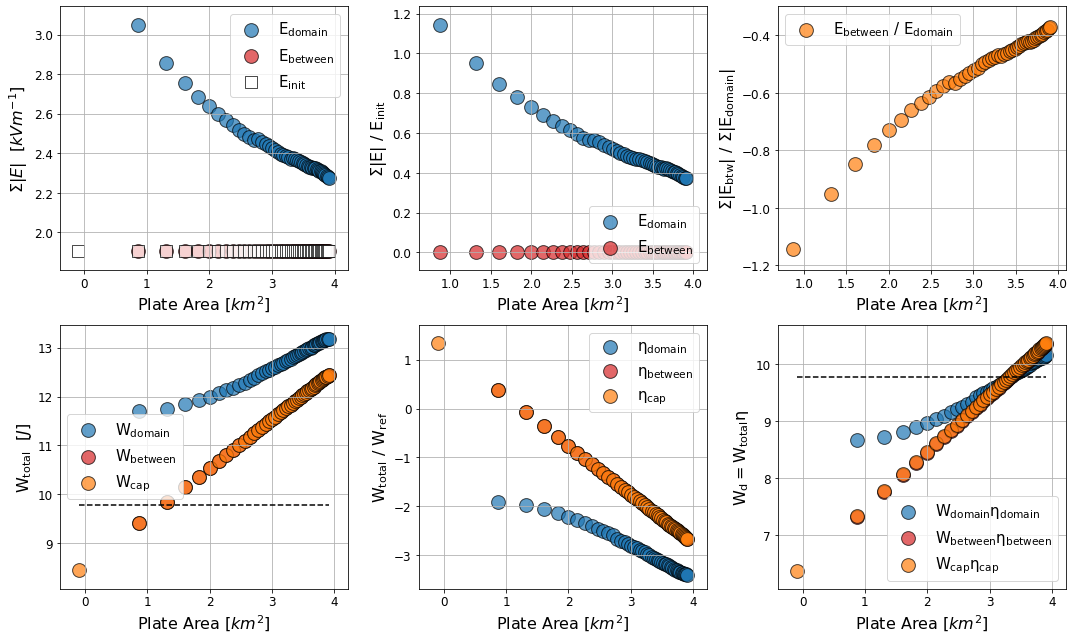

In [30]:
fig,ax = plt.subplots(2,3,figsize=(15,9))

#Efield Stats:
de = ax[0,0].scatter(np.log10(np.array(area)*1e-6),np.log10(np.array(dom_efield)),color='C0',marker='o',edgecolor='k',s=190,alpha=0.7)
be = ax[0,0].scatter(np.log10(np.array(area)*1e-6),np.log10(np.array(btw_efield)),color='C3',marker='o',edgecolor='k',s=190,alpha=0.7)
re = ax[0,0].scatter(np.log10(np.array(area)*1e-6),np.log10(np.array(ref_efield)),color='w', marker='s',edgecolor='k',s=140,alpha=0.7)
ax[0,0].legend([de,be,re],[r'$\rm E_{domain}$',r'$\rm E_{between}$',r'$\rm E_{init}$'],fontsize=15,loc='upper right')

de = ax[0,1].scatter(np.log10(np.array(area)*1e-6),np.log10(np.array(dom_efield)/np.array(ref_efield)),color='C0',marker='o',edgecolor='k',s=190,alpha=0.7)
be = ax[0,1].scatter(np.log10(np.array(area)*1e-6),np.log10(np.array(btw_efield)/np.array(ref_efield)),color='C3',marker='o',edgecolor='k',s=190,alpha=0.7)
ax[0,1].legend([de,be],[r'$\rm E_{domain}$',r'$\rm E_{between}$'],fontsize=15,loc='lower right')

ratio = ax[0,2].scatter(np.log10(np.array(area)*1e-6),np.log10(np.array(btw_efield)/np.array(dom_efield)),color='C1',marker='o',edgecolor='k',s=190,alpha=0.7)
ax[0,2].legend([ratio],[r'$\rm E_{between} \ / \ E_{domain}$'],fontsize=15)

#Energy Stats:
ref_energy = 6e9
eta_c = 10**np.nanmedian(np.log10(ref_energy/np.array(cap_energy)))
eta_d = 10**np.nanmedian(np.log10(ref_energy/np.array(dom_energy)))
eta_b = 10**np.nanmedian(np.log10(ref_energy/np.array(btw_energy)))


dw = ax[1,0].scatter(np.log10(np.array(area)*1e-6),np.log10(dom_energy),color='C0',marker='o',edgecolor='k',s=190,alpha=0.7)
bw = ax[1,0].scatter(np.log10(np.array(area)*1e-6),np.log10(btw_energy),color='C3',marker='o',edgecolor='k',s=190,alpha=0.7)
cw = ax[1,0].scatter(np.log10(np.array(area)*1e-6),np.log10(cap_energy),color='C1',marker='o',edgecolor='k',s=190,alpha=0.7)
ax[1,0].legend([dw,bw,cw],[r'$\rm W_{domain}$',r'$\rm W_{between}$',r'$\rm W_{cap}$'],fontsize=15)

deta = ax[1,1].scatter(np.log10(np.array(area)*1e-6),np.log10(ref_energy/np.array(dom_energy)),color='C0',marker='o',edgecolor='k',s=190,alpha=0.7)
beta = ax[1,1].scatter(np.log10(np.array(area)*1e-6),np.log10(ref_energy/np.array(btw_energy)),color='C3',marker='o',edgecolor='k',s=190,alpha=0.7)
ceta = ax[1,1].scatter(np.log10(np.array(area)*1e-6),np.log10(ref_energy/np.array(cap_energy)),color='C1',marker='o',edgecolor='k',s=190,alpha=0.7)
ax[1,1].legend([deta,beta,ceta],[r'$\rm \eta_{domain}$',r'$\rm \eta_{between}$',r'$\rm \eta_{cap}$'],fontsize=15)


dadj = ax[1,2].scatter(np.log10(np.array(area)*1e-6),np.log10(eta_d*np.array(dom_energy)),color='C0',marker='o',edgecolor='k',s=190,alpha=.7)
badj = ax[1,2].scatter(np.log10(np.array(area)*1e-6),np.log10(eta_b*np.array(btw_energy)),color='C3',marker='o',edgecolor='k',s=190,alpha=.7)
cadj = ax[1,2].scatter(np.log10(np.array(area)*1e-6),np.log10(eta_c*np.array(cap_energy)),color='C1',marker='o',edgecolor='k',s=190,alpha=.7)
ax[1,2].legend([dadj,badj,cadj],[r'$\rm W_{domain}\eta_{domain}$',r'$\rm W_{between}\eta_{between}$',r'$\rm W_{cap}\eta_{cap}$'],fontsize=15)


ax[0,0].set_ylabel(r'$\Sigma |E|$  [$kVm^{-1}$]',fontsize=16)
ax[0,1].set_ylabel(r'$\rm \Sigma |E| \ / \ E_{init}$',fontsize=16)
ax[0,2].set_ylabel(r'$\rm \Sigma |E_{btw}| \ / \ \Sigma |E_{domain}|$',fontsize=16)

ax[1,0].set_ylabel(r'$\rm W_{total}$  [$J$]',fontsize=16)
ax[1,1].set_ylabel(r'$\rm W_{total} \ / \ W_{ref}$',fontsize=16)
ax[1,2].set_ylabel(r'$\rm W_{d} = W_{total} \eta$',fontsize=16)

[axs.grid() for axs in ax.flatten()]
[axs.tick_params(labelsize=12) for axs in ax.flatten()]
[axs.set_xlabel(r'Plate Area [$km^2$]',fontsize=16) for axs in ax.flatten()]
plt.tight_layout()

ax[1,0].plot([np.log10(np.array(area)*1e-6).min(),np.log10(np.array(area)*1e-6).max()],[np.log10(6e9),np.log10(6e9)],'k--')
ax[1,2].plot([np.log10(np.array(area)*1e-6).min(),np.log10(np.array(area)*1e-6).max()],[np.log10(6e9),np.log10(6e9)],'k--')

In [12]:
np.nanmedian(np.array(btw_efield)/np.array(ref_efield))
eta_c,eta_d,eta_b,np.array(ref_efield)[0]

(0.008421581505076664,
 0.0009262189219519783,
 0.008091976951887646,
 80.5023470256137)

In [13]:
phi_all = np.array(potential)
e_all  = np.array(efield)
ebtw_all=(ebtw)

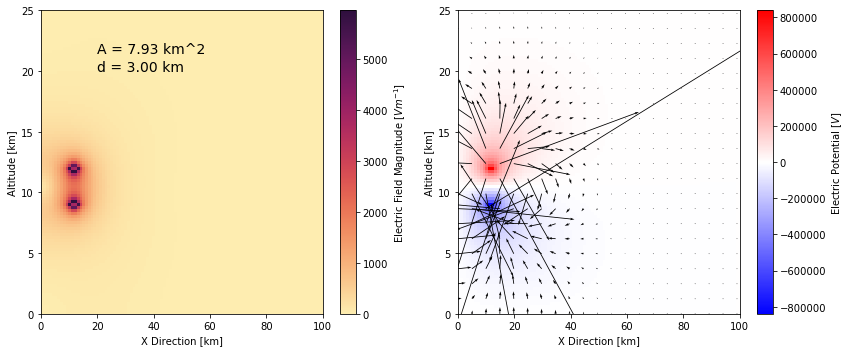

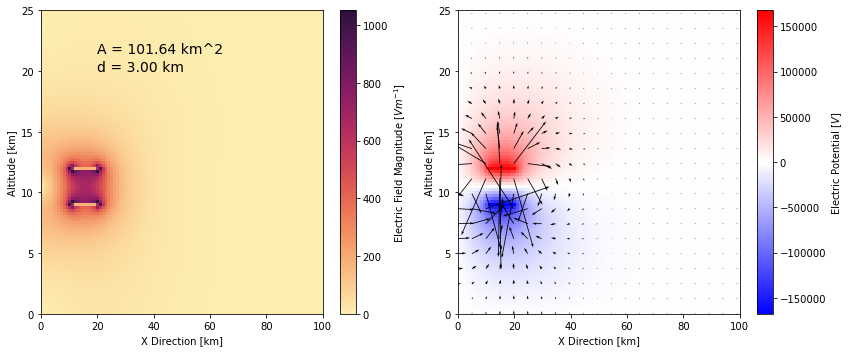

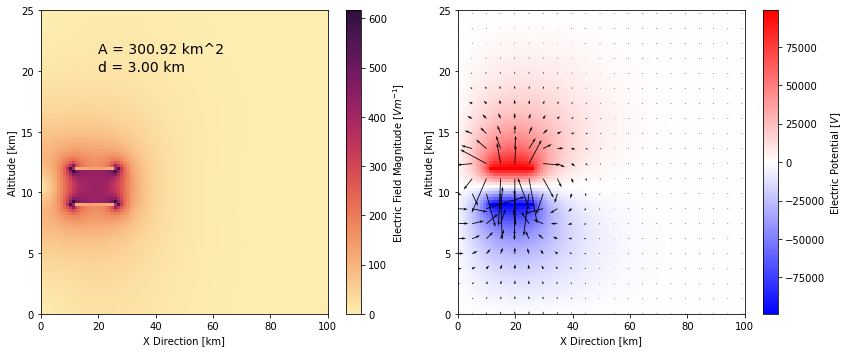

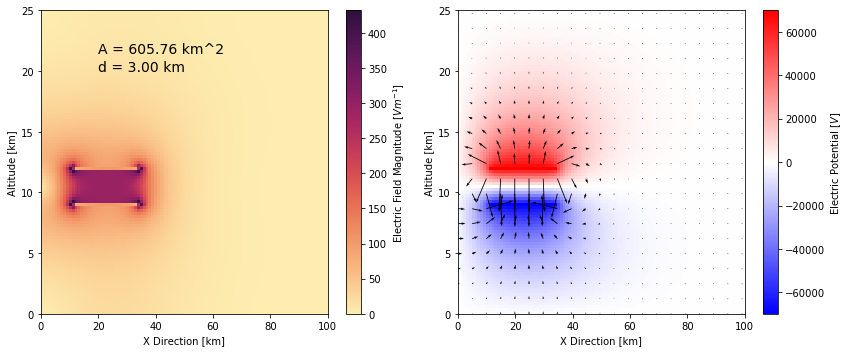

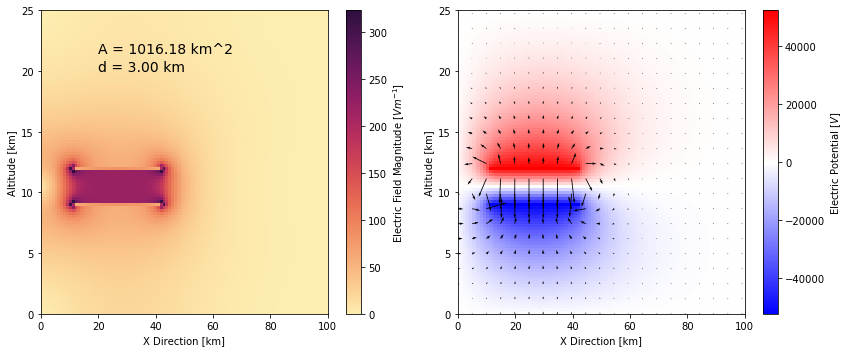

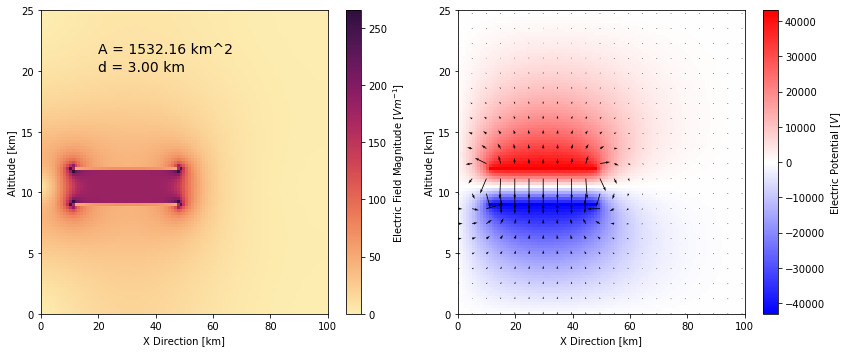

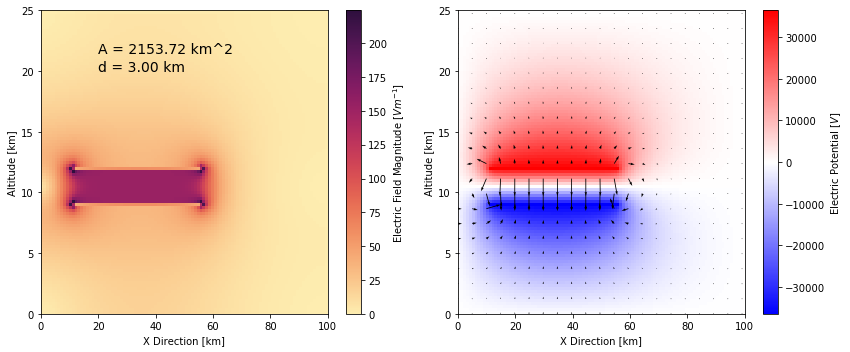

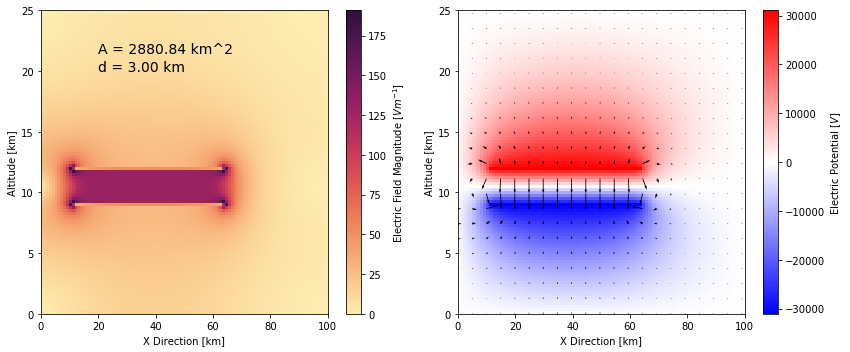

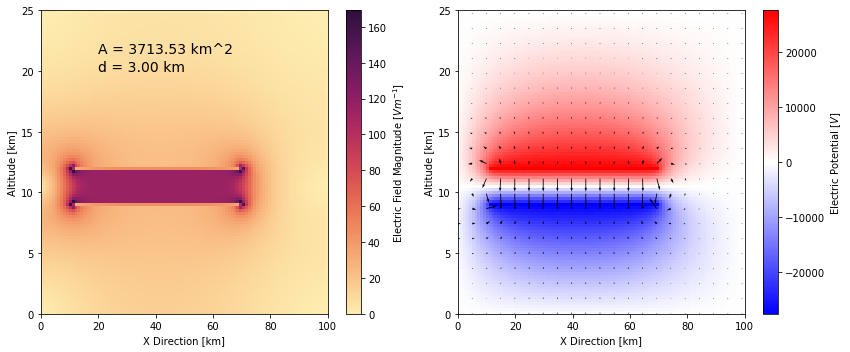

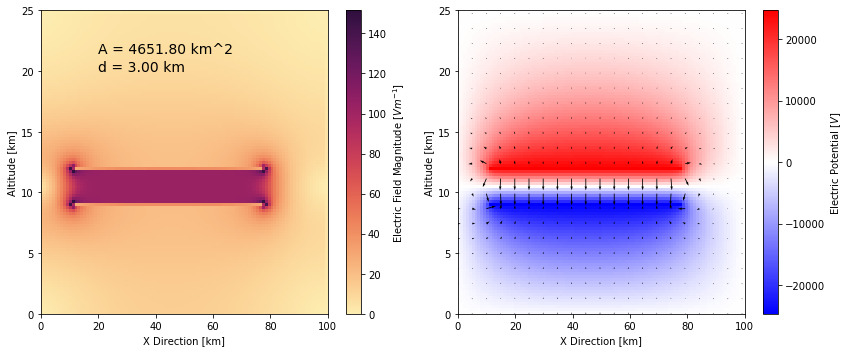

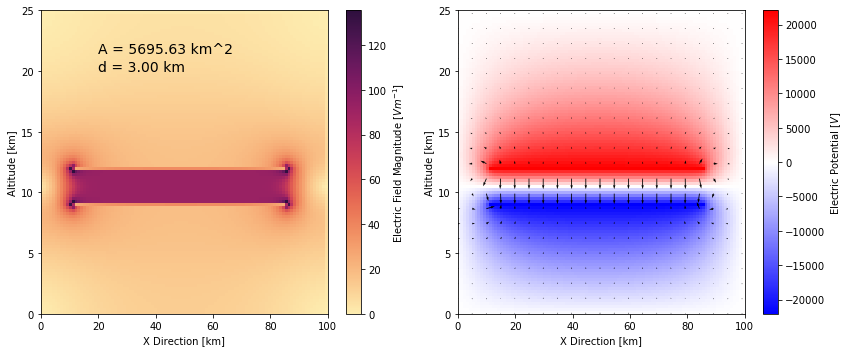

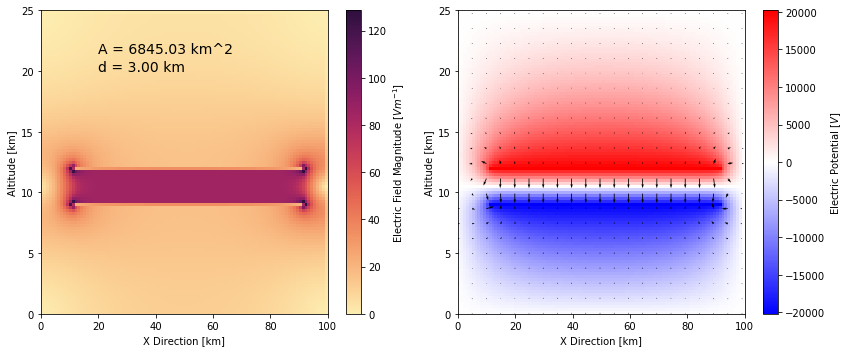

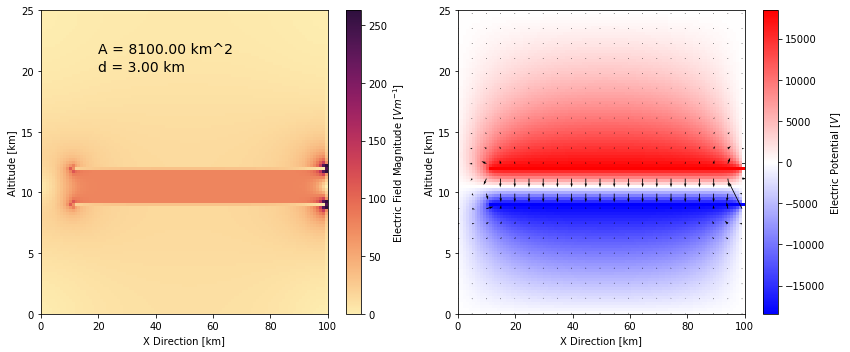

In [19]:
for i in np.arange(xf.shape[0])[1::4]:
    exs,eys = np.gradient(phi_all[i,:,:])
    exs=-exs
    eys=-eys
    
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    ef=ax[0].pcolormesh(xm,ym,(e_all[i,:,:]).T,cmap=cm.cm.matter)
    cb1 = plt.colorbar(ef,ax=ax[0])
    cb1.ax.set_ylabel(r'Electric Field Magnitude [$Vm^{-1}$]')
    ph=ax[1].pcolormesh(xm,ym,(phi_all[i,:,:]).T,cmap='bwr')
    cb2 = plt.colorbar(ph,ax=ax[1])
    cb2.ax.set_ylabel(r'Electric Potential [$V$]')
    ax[1].quiver(xm[::5,::5],ym[::5,::5],exs[::5,::5].T,eys[::5,::5].T,scale=1e5)
    
    ax[0].text(20,20,r'd = {0:.2f} km'.format((zt-zb)),fontsize=14)
    ax[0].text(20,21.5,r'A = {0:.2f} km^2'.format((xf[i]-xi)**2.),fontsize=14)

    for axs in ax.flatten():
        axs.set_xlabel('X Direction [km]')
        axs.set_ylabel('Altitude [km]')
    
    plt.tight_layout()


Eta Histograms:
--

In [31]:
h0,xe,ye = np.histogram2d(np.log10(np.array(area)[1:]*1e-6),np.log10(np.array(sep)[1:]*1e-3),bins=(15,15))
hc,xe,ye = np.histogram2d(np.log10(np.array(area)[1:]*1e-6),np.log10(np.array(sep)[1:]*1e-3),bins=(15,15),weights=(ref_energy/np.array(cap_energy))[1:])
hd,xe,ye = np.histogram2d(np.log10(np.array(area)[1:]*1e-6),np.log10(np.array(sep)[1:]*1e-3),bins=(15,15),weights=(ref_energy/np.array(dom_energy))[1:])
hb,xe,ye = np.histogram2d(np.log10(np.array(area)[1:]*1e-6),np.log10(np.array(sep)[1:]*1e-3),bins=(15,15),weights=(ref_energy/np.array(btw_energy))[1:])

/Users/vsalinas/miniconda3/envs/gui/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


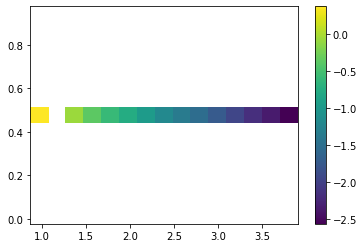

In [32]:
plt.pcolormesh(xe,ye,np.log10(hc/h0).T)
plt.colorbar()

/Users/vsalinas/miniconda3/envs/gui/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


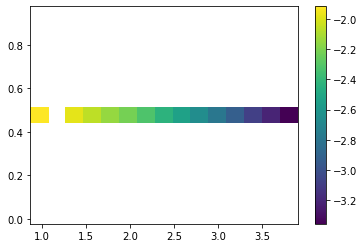

In [33]:
plt.pcolormesh(xe,ye,np.log10(hd/h0).T)

plt.colorbar()

/Users/vsalinas/miniconda3/envs/gui/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


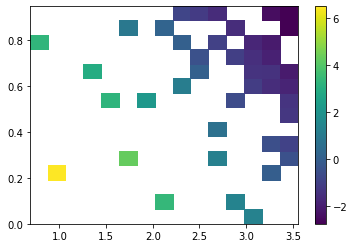

In [401]:
plt.pcolormesh(xe,ye,np.log10(hb/h0).T)
plt.colorbar()